In [68]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

In [69]:
torch.manual_seed(42)

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [71]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [72]:
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

In [73]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [74]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [75]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

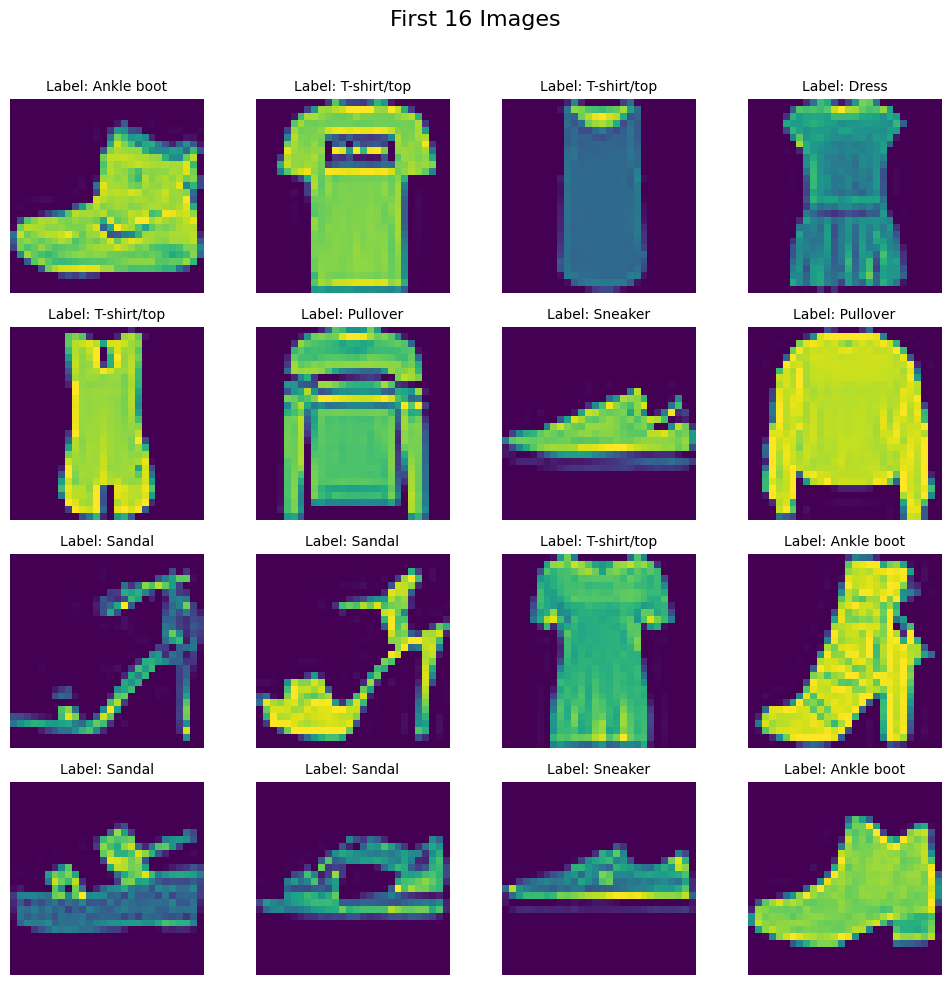

In [76]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Create a 4x4 grid
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images
for i, ax in enumerate(axes.flat):
    img = train_dataset.data[i]  # Extract image (shape: 32x32x3)
    
    ax.imshow(img)  # Show the RGB image
    ax.axis('off')  # Remove axis for a cleaner look
    
    # Get the class label
    label_idx = train_dataset.targets[i]  # Get class index
    label = train_dataset.classes[label_idx]  # Convert index to class name
    
    ax.set_title(f"Label: {label}", fontsize=10)  # Display label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()

In [77]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2)

In [78]:
# fetch the pretrained model
model = models.vgg16(pretrained=True)

In [79]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [80]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [81]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [82]:
for params in model.features.parameters():
    params.requires_grad = False

In [83]:
len(train_dataset.classes)

10

In [84]:
model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, len(train_dataset.classes))
)

In [85]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [86]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=10, bias=True)
)

In [87]:
model = model.to(device)

In [88]:
loss_fc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [89]:
# training loop

import time
start_time = time.time()

epochs = 10
running_loss1 = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for features , label in train_loader:
        features, label = features.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_fc(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss1.append(running_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time is {total_time / 60} Minutes!")

Epoch [1/10], Loss: 0.4532
Epoch [2/10], Loss: 0.3740
Epoch [3/10], Loss: 0.3340
Epoch [4/10], Loss: 0.3107
Epoch [5/10], Loss: 0.3047
Epoch [6/10], Loss: 0.2813
Epoch [7/10], Loss: 0.2702
Epoch [8/10], Loss: 0.2690
Epoch [9/10], Loss: 0.2556
Epoch [10/10], Loss: 0.2464
Total training time is 98.89154873291652 Minutes!


In [90]:
model.eval()
correct = 0
total = 0
accuracy1 = []

with torch.no_grad():
    for feature, labels in test_loader:
        feature, labels = feature.to(device), labels.to(device)
        outputs = model(feature)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy1.append(100 * correct / total)
        

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 92.25%


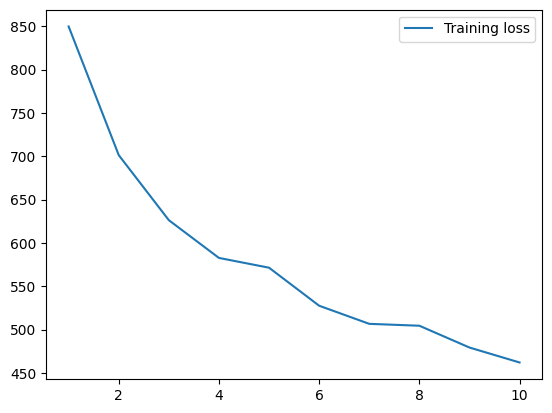

In [94]:
ep = [1,2,3,4,5,6,7,8,9,10]
plt.plot(ep, running_loss1, label="Training loss")
plt.legend()
plt.show()

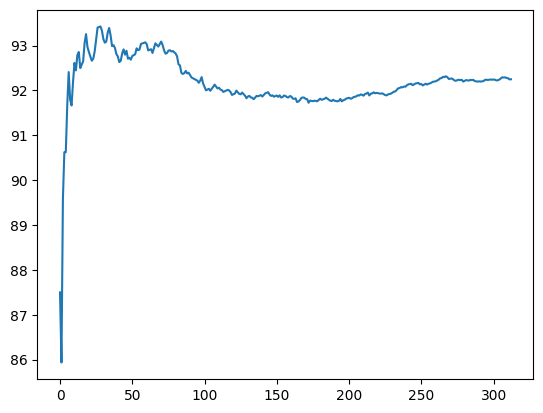

In [98]:
plt.plot(accuracy1)
plt.show()